<a href="https://colab.research.google.com/github/virf96/Proyectos/blob/master/M%C3%A9todos_para_SeriesConstantes_Promedios_Moviles_y_Suavizado_Exponencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Técnicas de Suavizado 

In [4]:
import pandas as pd
import numpy as np

In [5]:
#Utilizamos "index_col" para indexar los meses
#Utilizamos "parse_dates" para convertir los datos a fecha
airline = pd.read_csv('https://raw.githubusercontent.com/virf96/curso-series-temporales/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/airline_passengers.csv',
                      index_col='Month',parse_dates=True)

In [8]:
#Verificamos que no haya NA's en el data frame
airline.isna().sum()

Thousands of Passengers    0
dtype: int64

In [9]:
#Nos deshacemos de los datos faltantes "NA´s"
airline.dropna(inplace=True)

In [10]:
airline.head()

Thousands of Passengers
Month                              
1949-01-01                      112
1949-02-01                      118
1949-03-01                      132
1949-04-01                      129
1949-05-01                      121

___
# SMA
## Simple Moving Average : Promedio móvil simple

$SMA=\frac{x_1+x_2+...+x_n}{n} $

donde $x_i$ son los valores de la variable, por tanto $SMA$ es un promedio aritmético de $n$ períodos atrás.

### Desventajas

$\bullet$ Al ser un promedio aritmético, **los primeros periodos siempre serán missings** dado que no hay valores con los cuales hacer un promedio aritmético.

$\bullet$ **No utiliza ninguna ponderación** sobre las observaciones más recientes, es decir todas valen lo mismo.

$\bullet$ Es importante **no escoger ventas temporales tan pequeñas ni tan grandes** para que la estimación sea más precisa, esto lo podemos validar mediante una función de pérdida y verificar la precisión con distintas ventas temporales.

In [11]:
#Creamos las nuevas variables "6-month-SMA" y "12-month-SMA" 
#Seleccionamos la variable a suavizar y le aplicamos la función "rolling" indicando la ventana temporal sobre la que se harán los promedios
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

In [13]:
#Para el caso de el suavizamiento con ventana temporal de 6 meses, tengo valores hasta el 6to mes dado que antes no tengo datos por lo cuál la operación es 753/6
#Lo mismo ocurre para a ventana temporal de 12 meses
airline.head(15)

Thousands of Passengers  6-month-SMA  12-month-SMA
Month                                                         
1949-01-01                      112          NaN           NaN
1949-02-01                      118          NaN           NaN
1949-03-01                      132          NaN           NaN
1949-04-01                      129          NaN           NaN
1949-05-01                      121          NaN           NaN
1949-06-01                      135   124.500000           NaN
1949-07-01                      148   130.500000           NaN
1949-08-01                      148   135.500000           NaN
1949-09-01                      136   136.166667           NaN
1949-10-01                      119   134.500000           NaN
1949-11-01                      104   131.666667           NaN
1949-12-01                      118   128.833333    126.666667
1950-01-01                      115   123.333333    126.916667
1950-02-01                      126   119.666667    127.583333
1950-03-01                      141   120.500000    128.333333

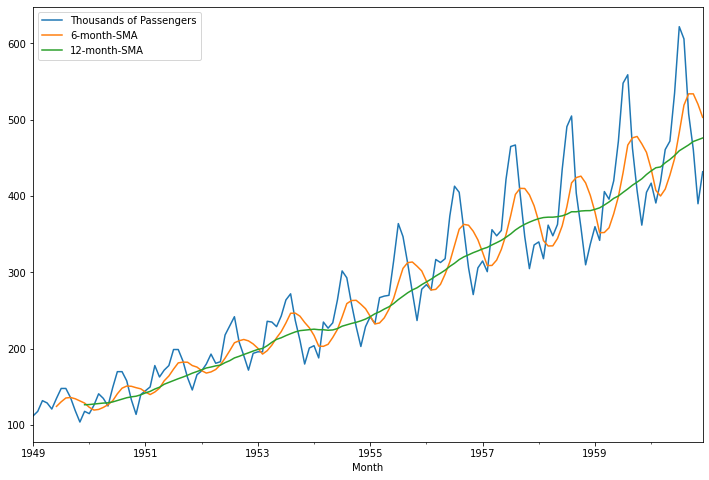

In [15]:
#Podemos ver que entre más grande sea la ventana temporal, el suavizamiento de la serie es más notorio
airline.plot(figsize=(12,8));

___
# EWMA
## Exponentially Weighted Moving Average: Promedio móvil ponderado exponencialmente



EWMA nos permitirá reducir el efecto de retraso de SMA y pondrá más peso en los valores que ocurrieron más recientemente. La cantidad de peso aplicada a los valores más recientes dependerá de los parámetros utilizados en EWMA, la fórmula con la que se calculan las estimaciones es:

### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Donde $x_t$ son los valores de la variable, $w_i$ son los pesos (desde $i=0$ hasta $t$), y la $y_t$ es la estimación resultante.

La pregunta es ¿cómo se deben definir los pesos $w_i$?

Esto depende del argumento <tt>adjust</tt> dentro de la función <tt>.ewm()</tt>.

Cuando <tt>adjust=True</tt> (por defecto), los pesos se calculan con esta ecuación: $w_i = (1 - \alpha)^i$

Lo cual resulta en estas estimaciones:

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$, donde $0<\alpha\leq1$ 

Por lo que entre más antigua sea la observación tendrá menos peso, dado que su ponderación es más pequeña, es decir influira menos en la estimación calculada.

Cuando <tt>adjust=False</tt> las estimaciones se calculan como:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

que es equivalente a usar estos pesos:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{si } i < t \\
    (1 - \alpha)^i        & \text{si } i = t.
\end{cases}\end{split}

El parámetro de suavizado $\alpha$ tiene que ser un valor $0<\alpha≤1$.
Es posible pasar directamente el valor del parámetro, pero una mejor práctica es pensar en él como una función de estos tres posibles factores:
1. Span (duración)
2. Center of mass (centro de masa)
3. Half-life (vida media)

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{para una duracion (span)}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{para un centro de masa}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{para un parametro half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponde a lo que comúnmente se llama un "promedio móvil de N-períodos"
* <strong>Center of mass</strong> tiene una interpretación más física y se puede pensar en términos de la duración: $c=(s−1)/2$
* <strong>Half-life</strong> es el período de tiempo para que el peso exponencial se reduzca a la mitad.
* <strong>Alpha</strong> es el parámetro de suavizado directamente.

Tenemos que pasar alguno de esos argumentos a la función. En nuestro ejemplo vamos a usar <tt>span=12</tt>.

In [16]:
#Creo una nueva variable "EWMA12"
#Escojo la serie a la cuál se le aplicara el suavizamiento 
#Y le indico la ventana temporal del promedio móvil ponderado exponencialmente
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

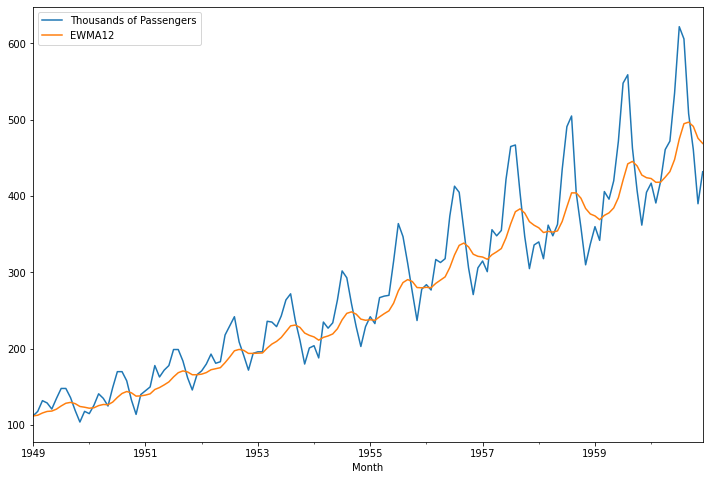

In [17]:
# Veamos que al inicio de la serie suavizada el comportamiento es más suavizado al principio y menos al final
#Esto por que hemos especificado que las observaciones más recientes sean más importantes que las antiguas
#Además para este método no existe el problema de missing en el calculo de los primeros periodos
airline[['Thousands of Passengers','EWMA12']].plot(figsize=(12,8));


## Comparación de SMA y EWMA

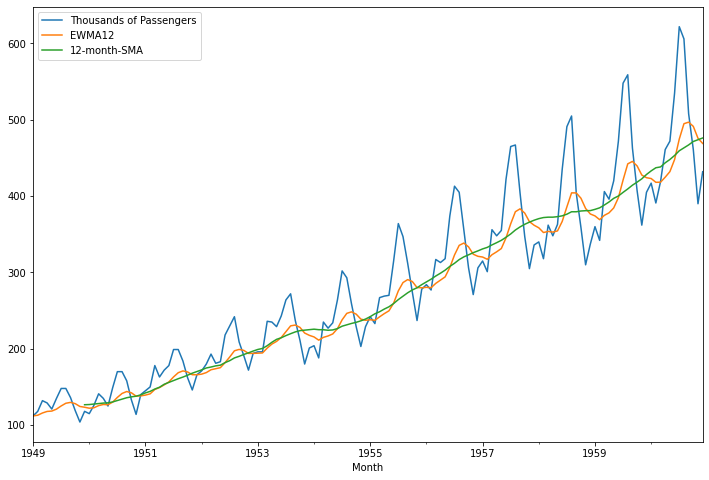

In [ ]:
#Comparemos los métodos
#Veamos como cuando no se aplican ponderaciones el suavizamiento es más notorio por lo que no recoge tan bien la información de los periodos
#además de problemas con missings
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8));

## Suavizado exponencial simple
El ejemplo anterior hemos empleado una especie de <em> Suavizado exponencial simple </em> con un factor de suavizado <strong> α </strong>. Desafortunadamente, esta técnica hace un mal trabajo de pronóstico cuando hay una tendencia en los datos como se ve arriba. En la siguiente sección veremos <em> Suavizado exponencial doble </em>  y <em> triple </em> con el método Holt-Winters.